In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data_dir = "data_thesis"  
all_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv.gz")])

df_list = []

for file in all_files:
    df_tmp = pd.read_csv(file)

    # Keep only top 5 levels
    keep_cols = ['timestamp', 'local_timestamp', 'exchange', 'symbol']
    for i in range(5):
        keep_cols += [f'asks[{i}].price', f'asks[{i}].amount', f'bids[{i}].price', f'bids[{i}].amount']
    
    df_tmp = df_tmp[keep_cols]
    df_list.append(df_tmp)

df = pd.concat(df_list, ignore_index=True)

In [5]:
df["spread"] = df["asks[0].price"] - df["bids[0].price"]
df["total_ask_volume"] = sum(df[f"asks[{i}].amount"] for i in range(5))
df["total_bid_volume"] = sum(df[f"bids[{i}].amount"] for i in range(5))

In [7]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

In [9]:
df["order_imbalance"] = (df["total_bid_volume"] - df["total_ask_volume"]) / (
    df["total_bid_volume"] + df["total_ask_volume"] + 1e-8
)
df["mid_price"] = (df["asks[0].price"] + df["bids[0].price"]) / 2
df["log_return"] = np.log(df["mid_price"] / df["mid_price"].shift(1))
df["rolling_volatility"] = df["log_return"].rolling(window=100).std()
df['mid_return'] = df['mid_price'].pct_change().fillna(0)

In [10]:
class StableBaselinesTradingEnvironment(gym.Env):
    def __init__(self, env_config):
        super().__init__()
        self.inner_env = DogeQuoteEnv(**env_config)
        self.action_space = self.inner_env.action_space
        self.observation_space = self.inner_env.observation_space

    def reset(self, *, seed=None, options=None):
        obs, info = self.inner_env.reset(seed=seed, options=options)
        return obs, info

    def step(self, action):
        return self.inner_env.step(action)

    def render(self):
        self.inner_env.render()

    @property
    def pnl_history(self):
        return self.inner_env.pnl_history

    @property
    def inventory_history(self):
        return self.inner_env.inventory_history

In [27]:
class DogeQuoteEnv(gym.Env):
    def __init__(self, df, quote_depths=None, fee=0.001, max_inventory=10, phi=0.0002, alpha=0.0001, kappa=1.5):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.fee = fee
        self.max_inventory = max_inventory
        self.phi = phi
        self.alpha = alpha
        self.kappa = kappa
        self.quote_depths = quote_depths or [0.0001, 0.0002, 0.0003]
        self.action_map = self._generate_action_map()
        self.action_space = spaces.Discrete(len(self.action_map))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

    def _generate_action_map(self):
        return [(bid, ask) for bid in self.quote_depths for ask in self.quote_depths]

    def reset(self, *, seed=None, options=None):
        self.balance = 1000.0
        self.inventory = 0
        self.step_idx = 1
        self.prev_pnl = 0
        self.pnl_history = []
        self.inventory_history = []
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.df.iloc[self.step_idx]
        time_left = 1.0 - (self.step_idx / len(self.df))
        return np.array([
            row['spread'],
            row['rolling_volatility'],
            row['order_imbalance'],
            row['mid_price'],
            row['mid_return'],
            self.inventory,
            time_left
        ], dtype=np.float32)

    def _fill_probability(self, delta):
        return np.exp(-self.kappa * delta)

    def step(self, action):
        bid_offset, ask_offset = self.action_map[action]
        row = self.df.iloc[self.step_idx]
        mid_price = row['mid_price']
        bid_price = mid_price - bid_offset
        ask_price = mid_price + ask_offset
        market_bid = row['bids[0].price']
        market_ask = row['asks[0].price']

        filled_bid = False
        filled_ask = False

        if np.random.rand() < 0.5:
            if self.inventory < self.max_inventory and self.balance >= bid_price:
                prob = self._fill_probability(abs(market_ask - bid_price))
                if np.random.rand() < prob:
                    self.inventory += 1
                    self.balance -= bid_price * (1 + self.fee)
                    filled_bid = True
        else:
            if self.inventory > -self.max_inventory:
                prob = self._fill_probability(abs(ask_price - market_bid))
                if np.random.rand() < prob:
                    self.inventory -= 1
                    self.balance += ask_price * (1 - self.fee)
                    filled_ask = True

        self.step_idx += 1
        done = self.step_idx >= len(self.df) - 1

        next_mid = self.df.iloc[self.step_idx]['mid_price']
        net_worth = self.balance + self.inventory * next_mid
        incremental_reward = (net_worth - self.prev_pnl)
        self.prev_pnl = net_worth

        spread_capture = (ask_price - bid_price) if filled_bid and filled_ask else 0

        running_penalty = self.phi * abs(self.inventory)**2 + 0.3 * max(0, -self.inventory)**2
        terminal_penalty = self.alpha * self.inventory ** 2 if done else 0

        reward = (incremental_reward + spread_capture - running_penalty - terminal_penalty) / 10.0

        self.pnl_history.append(net_worth)
        self.inventory_history.append(self.inventory)

        return self._get_obs(), reward, done, False, {}

    def render(self):
        print(f"Step {self.step_idx} | Balance: {self.balance:.2f} | Inventory: {self.inventory}")

In [29]:
env_config = {"df": df}
env = DummyVecEnv([lambda: StableBaselinesTradingEnvironment(env_config)])
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=500_000)
model.save("dqn_mbt_style_market_maker")

env_instance = env.envs[0]
obs, _ = env_instance.reset()
done = False
max_steps = 1000 # can't handle all steps, trying on limit number
step_count = 0
while not done and step_count < max_steps:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env_instance.step(action)
    env_instance.render()
    step_count += 1

Using cpu device
Step 2 | Balance: 999.68 | Inventory: 1
Step 3 | Balance: 999.37 | Inventory: 2
Step 4 | Balance: 999.05 | Inventory: 3
Step 5 | Balance: 999.37 | Inventory: 2
Step 6 | Balance: 999.68 | Inventory: 1
Step 7 | Balance: 999.37 | Inventory: 2
Step 8 | Balance: 999.68 | Inventory: 1
Step 9 | Balance: 999.37 | Inventory: 2
Step 10 | Balance: 999.05 | Inventory: 3
Step 11 | Balance: 998.73 | Inventory: 4
Step 12 | Balance: 998.42 | Inventory: 5
Step 13 | Balance: 998.10 | Inventory: 6
Step 14 | Balance: 997.79 | Inventory: 7
Step 15 | Balance: 998.10 | Inventory: 6
Step 16 | Balance: 998.42 | Inventory: 5
Step 17 | Balance: 998.73 | Inventory: 4
Step 18 | Balance: 998.42 | Inventory: 5
Step 19 | Balance: 998.73 | Inventory: 4
Step 20 | Balance: 999.05 | Inventory: 3
Step 21 | Balance: 999.36 | Inventory: 2
Step 22 | Balance: 999.68 | Inventory: 1
Step 23 | Balance: 1000.00 | Inventory: 0
Step 24 | Balance: 999.68 | Inventory: 1
Step 25 | Balance: 999.99 | Inventory: 0
Step 2

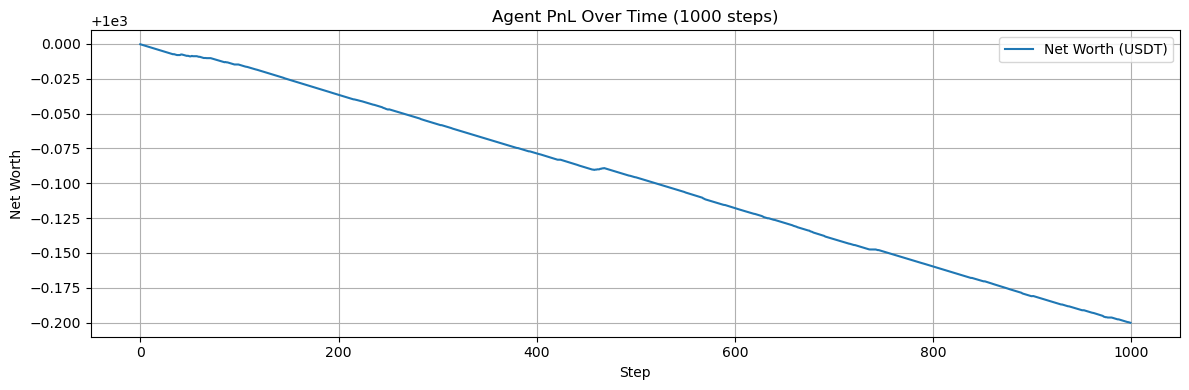

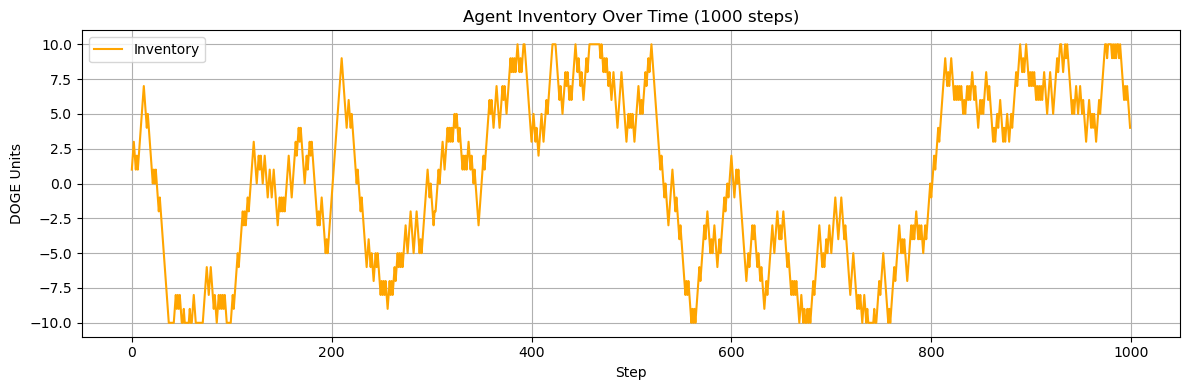

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(env_instance.pnl_history[:step_count], label="Net Worth (USDT)")
plt.title("Agent PnL Over Time (1000 steps)")
plt.xlabel("Step")
plt.ylabel("Net Worth")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(env_instance.inventory_history[:step_count], color='orange', label="Inventory")
plt.title("Agent Inventory Over Time (1000 steps)")
plt.xlabel("Step")
plt.ylabel("DOGE Units")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
